In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
import skimage
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [2]:
"""
import tarfile
file = tarfile.open('./BraTS2021_Training_Data.tar')
file.extractall('./brain_images')
file.close()
"""

"\nimport tarfile\nfile = tarfile.open('./BraTS2021_Training_Data.tar')\nfile.extractall('./brain_images')\nfile.close()\n"

In [284]:
import nibabel as nib
scan_path = "./brain_images/BraTS2021_00002/BraTS2021_00002_t2.nii.gz"
gt_path = "./brain_images/BraTS2021_00002/BraTS2021_00002_seg.nii.gz"
scan_obj = nib.load(scan_path)
gt_obj = nib.load(gt_path)
type(scan_obj)

scan_data = scan_obj.get_fdata()
print(type(scan_data))
scan_data.shape

gt_data = gt_obj.get_fdata()
print(type(gt_data))
gt_data.shape


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(240, 240, 155)

In [285]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
def visualize_3d_scan(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(scan_data[:, :, layer], cmap='gray')
    plt.axis('off')
    return layer

def visualize_3d_gt(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(gt_data[:, :, layer], cmap='gray')
    plt.axis('off')
    return layer

In [1]:
interact(visualize_3d_scan, layer=(0, scan_data.shape[2] - 1))
interact(visualize_3d_gt, layer=(0, gt_data.shape[2] - 1))


NameError: name 'interact' is not defined

In [297]:
slice_index = 106
def get_slice_pair(layer):
    return scan_data[:, :, layer],gt_data[:, :, layer]
scan_2d,gt_2d = get_slice_pair(slice_index)
ori_scan_2d = scan_2d

In [298]:
if scan_2d.shape[-1]>3 and len(scan_2d.shape)==3:
    scan_2d = scan_2d[:,:,:3]
if len(scan_2d.shape)==2:
    scan_2d = np.repeat(scan_2d[:,:,None], 3, axis=-1)

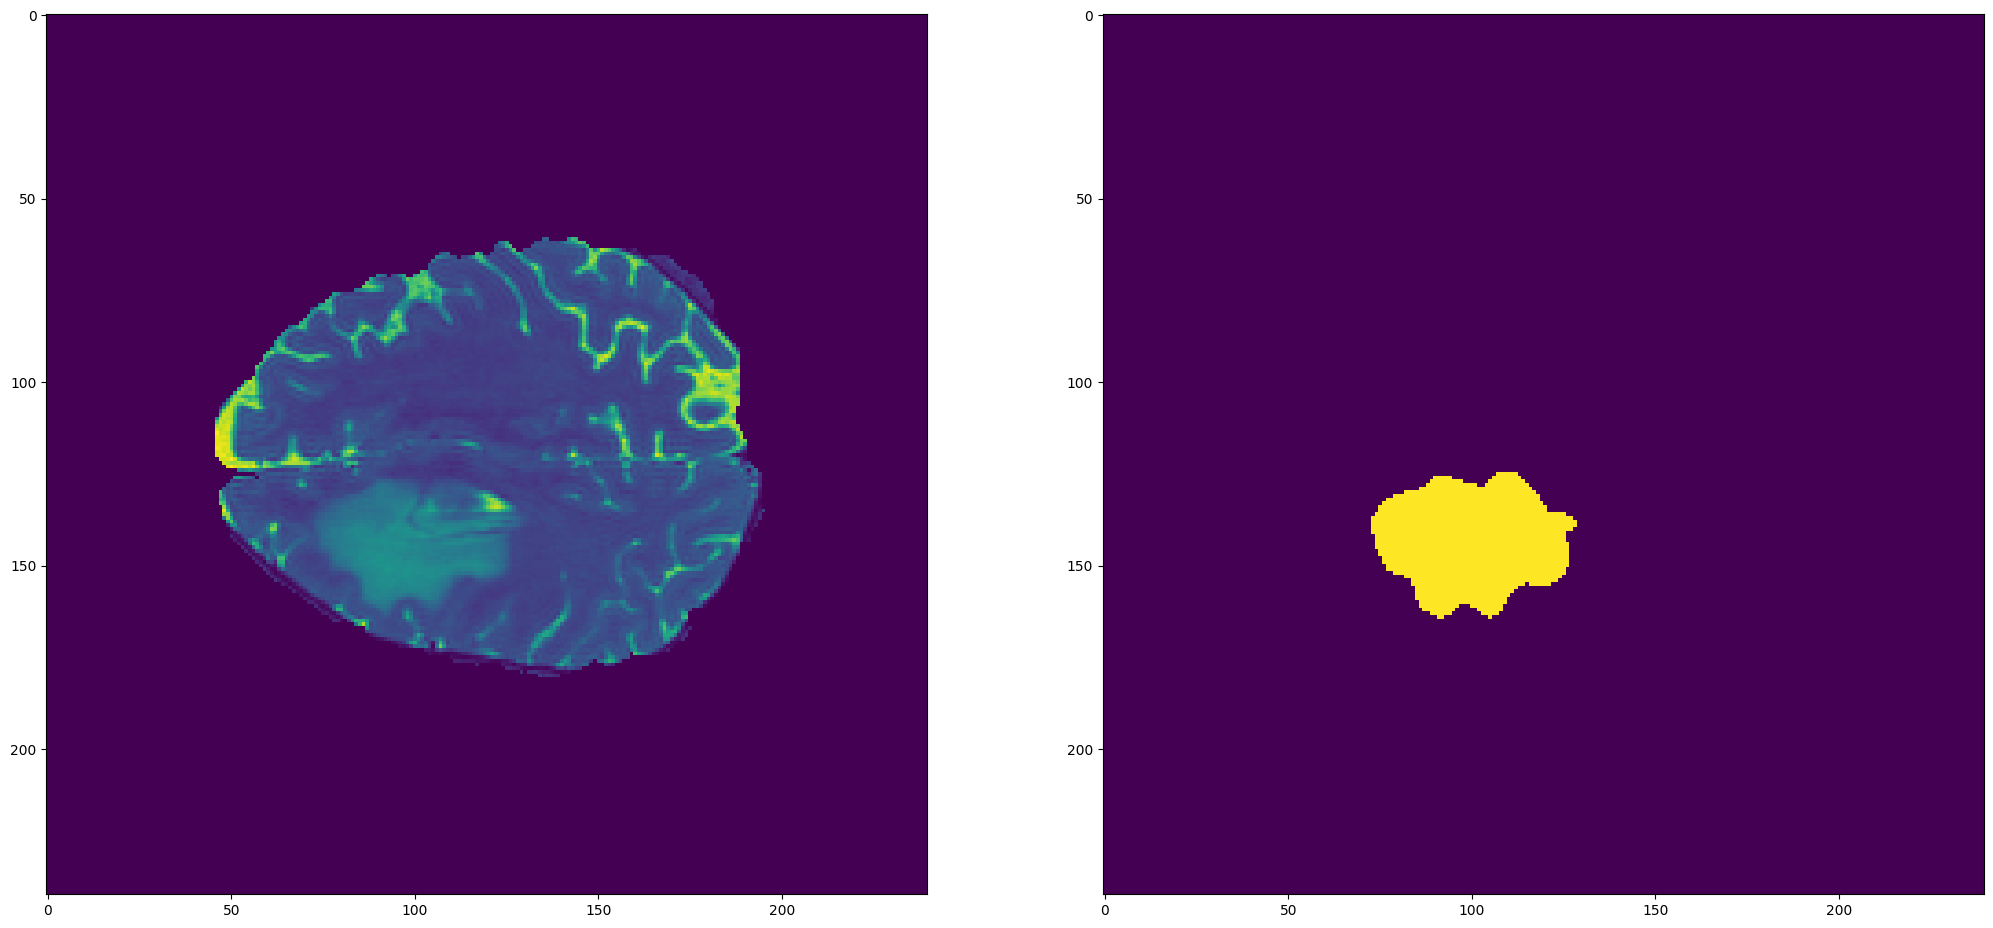

In [299]:
_, axs = plt.subplots(1, 2, figsize=(25, 25))
axs[0].imshow(ori_scan_2d)
axs[1].imshow(gt_2d)
plt.show() 
plt.close()

In [300]:
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])
bbox_raw = get_bbox_from_mask(gt_2d)
print(bbox_raw.shape)

(4,)


In [301]:
model_type = 'vit_b'
sam_model_checkpoint = './sam_vit_b_01ec64.pth'
med_sam_model_checkpoint = './med_sam_model_best.pth'
device = 'cuda:0'
sam_model = sam_model_registry[model_type](checkpoint=sam_model_checkpoint).to(device)
med_sam_model = sam_model_registry[model_type](checkpoint=med_sam_model_checkpoint).to(device)
sam_predictor = SamPredictor(sam_model)
med_sam_predictor = SamPredictor(med_sam_model)


lower_bound, upper_bound = np.percentile(scan_2d, 0.5), np.percentile(scan_2d, 99.5)
scan_2d_pre = np.clip(scan_2d, lower_bound, upper_bound)
scan_2d_pre = (scan_2d_pre - np.min(scan_2d_pre))/(np.max(scan_2d_pre)-np.min(scan_2d_pre))*255.0
scan_2d_pre[scan_2d==0] = 0
scan_2d_pre = np.uint8(scan_2d_pre)
H, W, _ = scan_2d_pre.shape

# predict the segmentation mask using the original SAM model
sam_predictor.set_image(scan_2d_pre)
sam_seg, _, _ = sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)
print(sam_seg.shape)


(1, 240, 240)


In [302]:
med_sam_transform = ResizeLongestSide(med_sam_model.image_encoder.img_size)
resize_img = med_sam_transform.apply_image(scan_2d_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = med_sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
assert input_image.shape == (1, 3, med_sam_model.image_encoder.img_size, med_sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = med_sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    bbox = med_sam_transform.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = med_sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = med_sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=med_sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    medsam_seg = skimage.transform.resize(medsam_seg,(240,240))
    medsam_seg = skimage.util.img_as_ubyte(medsam_seg)
    print(medsam_seg.shape)
    print(medsam_seg)
    


bbox_raw=array([ 54, 119, 131, 175]) -> bbox=array([[230, 507, 558, 746]])
(240, 240)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [304]:
sam_dsc = compute_dice_coefficient(gt_2d>0, sam_seg>0)
medsam_dsc = compute_dice_coefficient(gt_2d>0, medsam_seg>0)
print('Original SAM DSC: {:.4f}'.format(sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.7592 MedSAM DSC: 0.9174


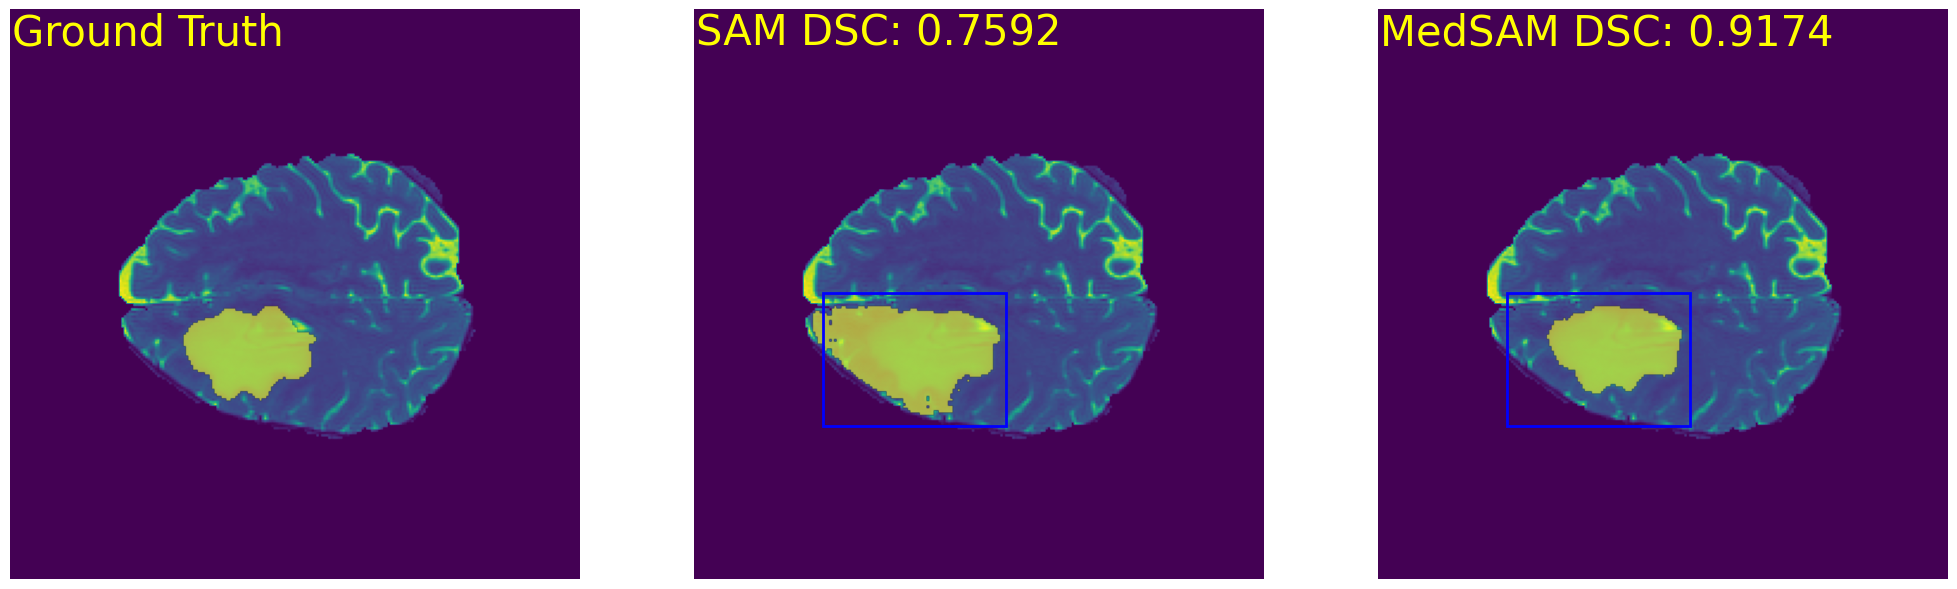

In [305]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
#scan_2d,gt_2d
axs[0].imshow(ori_scan_2d)
show_mask(gt_2d>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')
axs[0].text(0.5, 0.5, 'Ground Truth', fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
axs[1].imshow(ori_scan_2d)
show_mask(sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(ori_scan_2d)
show_mask(medsam_seg, axs[2])
show_box(bbox_raw, axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()

In [306]:
import glob

def get_2_dice_scores_of_scan(image,gt):
    ##SAM original
    lower_bound, upper_bound = np.percentile(image, 0.5), np.percentile(image, 99.5)
    image_pre = np.clip(image, lower_bound, upper_bound)
    image_pre = (image_pre - np.min(image_pre))/(np.max(image_pre)-np.min(image_pre))*255.0
    image_pre[image==0] = 0
    image_pre = np.uint8(image_pre)
    H, W, _ = image_pre.shape

    # predict the segmentation mask using the original SAM model
    sam_predictor.set_image(image_pre)
    sam_seg, _, _ = sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)
    
    ##Fine-tuned SAM

    med_sam_transform = ResizeLongestSide(med_sam_model.image_encoder.img_size)
    resize_img = med_sam_transform.apply_image(image_pre)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = med_sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    assert input_image.shape == (1, 3, med_sam_model.image_encoder.img_size, med_sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

    with torch.no_grad():
        # pre-compute the image embedding
        ts_img_embedding = med_sam_model.image_encoder(input_image)
        # convert box to 1024x1024 grid
        bbox = med_sam_transform.apply_boxes(bbox_raw, (H, W))
        #print(f'{bbox_raw=} -> {bbox=}')
        box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = med_sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = med_sam_model.mask_decoder(
            image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
            image_pe=med_sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
        medsam_seg = skimage.transform.resize(medsam_seg,(240,240))
        medsam_seg = skimage.util.img_as_ubyte(medsam_seg)


    sam_dsc = compute_dice_coefficient(gt_2d>0, sam_seg>0)
    medsam_dsc = compute_dice_coefficient(gt_2d>0, medsam_seg>0)

    return sam_dsc,medsam_dsc



In [296]:
#print(os.listdir("./brain_images/"))
print(os.listdir("./brain_images/BraTS2021_01401/"))

['BraTS2021_01401_t1.nii.gz', 'BraTS2021_01401_seg.nii.gz', 'BraTS2021_01401_t1ce.nii.gz', 'BraTS2021_01401_flair.nii.gz', 'BraTS2021_01401_t2.nii.gz']


In [276]:
def get_statistic_socre_on_dataset(data_path):
    sam_scores_array = []
    medsam_scores_array = []
    scan_path_list = glob.glob(data_path+"/*")
    for scan_path in scan_path_list:
      scan_data_list = glob.glob(scan_path+"/*")
      image = nib.load(scan_data_list[4]).get_fdata() #t2 for example
      gt =  nib.load(scan_data_list[1]).get_fdata()
      slice_index = np.random.randint(10,140)
      image,gt = get_slice_pair(slice_index)
        
      if image.shape[-1]>3 and len(image.shape)==3:
        image = image[:,:,:3]
      if len(image.shape)==2:
        image = np.repeat(image[:,:,None], 3, axis=-1)
    
      sam_score, medsam_score =  get_2_dice_scores_of_scan(image,gt)
      sam_scores_array.append(sam_score)
      medsam_scores_array.append(medsam_score)
      #print(type(image))
      #print(gt.shape)
    sam_scores_array = np.array(sam_scores_array)
    medsam_scores_array = np.array(medsam_scores_array)
    print(np.average(sam_scores_array))
    print(np.average(medsam_scores_array))
    return sam_scores_array,medsam_scores_array


        
    
   
sam_scores_array, medsam_scores_array = get_statistic_socre_on_dataset("./brain_images")   

/tmp/ipykernel_49/1084508900.py:7: RuntimeWarning: invalid value encountered in true_divide
  image_pre = (image_pre - np.min(image_pre))/(np.max(image_pre)-np.min(image_pre))*255.0


0.6205792840783995
0.6938689988654013


<Axes: >

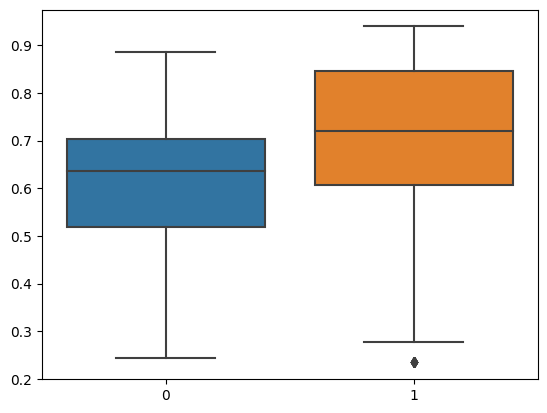

In [283]:
import seaborn as sns
all_arr = [sam_scores_array,medsam_scores_array]
sns.boxplot(data=all_arr)